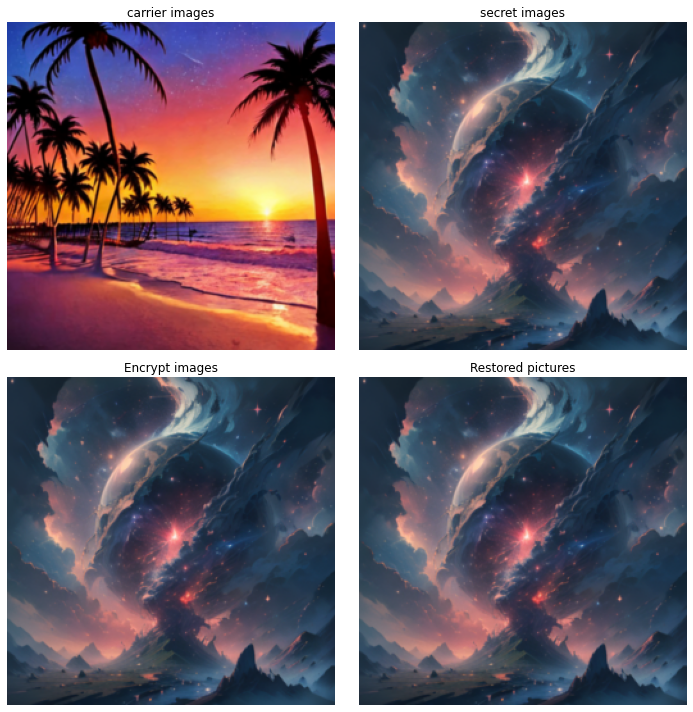

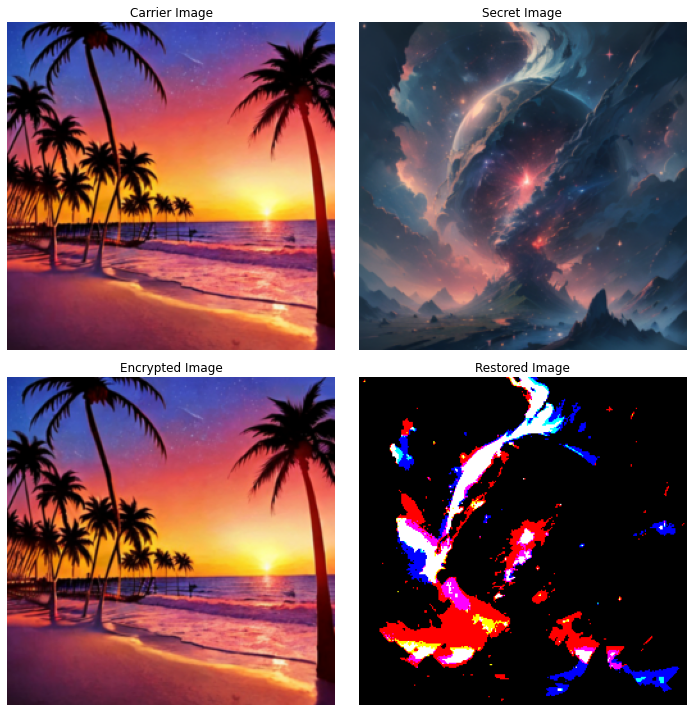

In [49]:
import torch
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

# 读取图像
carrier_image = Image.open('./resource/carrier.png').convert('RGB')
secret_image = Image.open('./resource/secret1.png').convert('RGB')

# 转换图像为Tensor，并保持0-255范围
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # 转换为[0, 1]范围
    transforms.Lambda(lambda x: (x * 255).byte())  # 还原到[0, 255]范围并转换为整数
])
carrier_tensor = transform(carrier_image)
secret_tensor = transform(secret_image)

# 获取图像的高度和宽度
H = carrier_tensor.shape[1]
W = carrier_tensor.shape[2]

# 将Tensor展平为一维
carrier_flat = carrier_tensor.view(-1).int()  # 转换为整数
secret_flat = secret_tensor.view(-1).int()

# 隐藏秘密图像到载体图像
new_tensor_flat = (carrier_flat & 0xFE) | (secret_flat >> 7)  # 将秘密图像的最高位嵌入载体图像的最低有效位
new_tensor = new_tensor_flat.view(3, H, W)

# 从加密图像中提取秘密图像
extracted_secret_flat = (new_tensor_flat & 1) * 255  # 提取秘密图像的最低有效位
extracted_secret_tensor = extracted_secret_flat.view(3, H, W)

# 显示图像
tensor_list = [carrier_tensor, secret_tensor, new_tensor, extracted_secret_tensor]
title = ['Carrier Image', 'Secret Image', 'Encrypted Image', 'Restored Image']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, (tensor, ax) in enumerate(zip(tensor_list, axs.ravel())):
    ax.imshow(tensor.permute(1, 2, 0).numpy())
    ax.axis('off')
    ax.set_title(title[i])
plt.tight_layout()
plt.show()


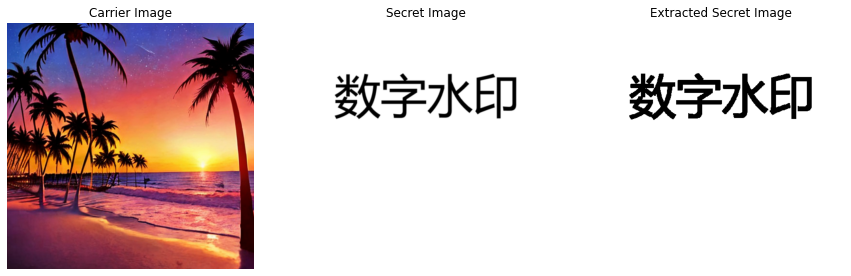

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取载体图像和秘密图像
carrier_img = cv2.imread('./resource/carrier.png')
secret_img = cv2.imread('./resource/secret.png')

# 确保图像大小相同
assert carrier_img.shape == secret_img.shape, "载体图像和秘密图像的大小必须相同"

def hide_image(carrier_img, secret_img):
    secret_img_gray = cv2.cvtColor(secret_img, cv2.COLOR_BGR2GRAY)
    secret_img_bin = secret_img_gray // 255
    carrier_img_lsb = carrier_img & 0xFE
    stego_img = carrier_img_lsb | (secret_img_bin[:, :, np.newaxis] * 1)
    return stego_img

def extract_image(stego_img):
    secret_img_bin = stego_img & 0x01
    secret_img = secret_img_bin * 255
    return secret_img.astype(np.uint8)

# 隐藏和提取
stego_img = hide_image(carrier_img, secret_img)
cv2.imwrite('stego_image.png', stego_img)

extracted_secret_img = extract_image(stego_img)
cv2.imwrite('extracted_secret_image.png', extracted_secret_img)

# 显示图像
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 载体图像
axes[0].imshow(cv2.cvtColor(carrier_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Carrier Image')
axes[0].axis('off')

# 秘密图像
axes[1].imshow(cv2.cvtColor(secret_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('Secret Image')
axes[1].axis('off')

# 恢复的秘密图像（直接显示灰度图像）
axes[2].imshow(extracted_secret_img, cmap='gray')
axes[2].set_title('Extracted Secret Image')
axes[2].axis('off')

plt.show()
